# Gather and format TC observations

In this script
- Read EM-DAT observations
- Read NCCS event data (for event names and metadata)
- Match observations to events

## TODO
- This uses an old version of EM-DAT pacakged with CLIMADA and doesn't have recent years in it. Updating will be a little complex, since EM-DAT uses different event IDs from IBTrACS and therefore CLIMADA. There are event matching scripts somewhere within CLIMADA and Chris F has also got a crude one
- The tropical cyclone events are slowly being updated by the WCR group at ETH. These results may change as that happens (the calibration definitely will).

In [1]:
import sys
sys.path.append('../../..')  # Package root directory

import os
import logging
import datetime
import warnings
import pandas as pd
import numpy as np
import subprocess
from copy import deepcopy
from pathlib import Path
from climada.util import log_level
from climada.util.api_client import Client
from climada.util.constants import SYSTEM_DIR


logging.getLogger("climada").setLevel("WARNING")
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/Caskroom/miniforge/base/envs/nccs_dev_jupyter/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
emdat = pd.read_csv(Path(SYSTEM_DIR / "tc_impf_cal_v01_EDR.csv"))
output_dir = Path('/Users/chrisfairless/Projects/CelsiusPro/nccs-supply-chain/resources/observations/data/')
# emdat_subset = emdat[(emdat["cal_region2"] == "NA1") & (emdat["year"] >= 2010)]
print(emdat.columns)
emdat

Index(['country', 'region_id', 'cal_region2', 'year', 'EM_ID', 'ibtracsID',
       'emdat_impact', 'reference_year', 'emdat_impact_scaled',
       'climada_impact', 'v_thresh', 'v_half', 'scale', 'log_ratio',
       'unique_ID', 'Associated_disaster', 'Surge', 'Rain', 'Flood', 'Slide',
       'Other', 'OtherThanSurge'],
      dtype='object')


,country,region_id,cal_region2,year,EM_ID,ibtracsID,emdat_impact,reference_year,emdat_impact_scaled,climada_impact,...,scale,log_ratio,unique_ID,Associated_disaster,Surge,Rain,Flood,Slide,Other,OtherThanSurge
0,FJI,242,OC,1980,1980-0036,1980081S12170,2.256000e+06,2014,8.410828e+06,8.395962e+06,...,1.0,-0.001769,1980-0036FJI,False,False,False,False,False,False,False
1,USA,840,NA2,1980,1980-0080,1980214N11330,8.600000e+08,2014,5.264166e+09,5.256769e+09,...,1.0,-0.001406,1980-0080USA,False,True,False,False,False,False,False
2,PHL,608,WP2,1980,1980-0099,1980296N05165,1.023000e+08,2014,8.971498e+08,8.971620e+08,...,1.0,0.000014,1980-0099PHL,False,False,False,False,False,False,False
3,PHL,608,WP2,1980,1980-0133,1980126N08150,2.890000e+05,2014,2.534470e+06,2.539189e+06,...,1.0,0.001860,1980-0133PHL,False,False,False,False,False,False,False
4,PHL,608,WP2,1981,1981-0083,1981256N10150,6.700000e+06,2014,5.348970e+07,5.312658e+07,...,1.0,-0.006812,1981-0083PHL,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,VNM,704,WP1,2017,2017-0422,2017304N11127,1.000000e+09,2014,8.320885e+08,8.350470e+08,...,1.0,0.003549,2017-0422VNM,True,False,False,True,False,False,True
469,JPN,392,WP4,2017,2017-0432,2017288N09138,1.000000e+09,2014,9.954845e+08,9.951263e+08,...,1.0,-0.000360,2017-0432JPN,True,False,False,True,True,False,True
470,JPN,392,WP4,2017,2017-0468,2017252N14147,5.000000e+08,2014,4.977422e+08,6.226990e+08,...,1.0,0.223981,2017-0468JPN,True,False,False,True,True,False,True
471,CHN,156,WP3,2017,2017-0485,2017236N15129,5.600000e+07,2014,4.796758e+07,4.798365e+07,...,1.0,0.000335,2017-0485CHN,False,False,False,False,False,False,False


In [3]:
track_ids = emdat["ibtracsID"].unique()
region_ids_num = emdat["region_id"].unique()
region_ids_alpha = emdat["country"].unique()

data = pd.pivot_table(
    emdat,
    values="emdat_impact_scaled",
    index="ibtracsID",
    columns="region_id",
    # fill_value=0,
)
data

region_id,28,36,44,50,60,84,90,92,104,116,...,670,704,764,776,780,796,840,850,882,887
ibtracsID,,,,,,,,,,,,,,,,,,,,,
1980081S12170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980126N08150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980214N11330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.264166e+09,NaN,NaN,NaN
1980296N05165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981176N08150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017260N12310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017277N11279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.248062e+08,NaN,NaN,NaN
2017288N09138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We use the NCCS functions to get hazard, to make sure we're consistent when the data updates.

In [4]:
import pycountry
from climada.hazard import Hazard
from pipeline.direct.direct import get_hazard

country_iso3alpha = 'FJI'
haz = get_hazard("tropical_cyclone", country_iso3alpha=country_iso3alpha, scenario='None', ref_year='historical')

In [5]:
haz_name_list = [get_hazard("tropical_cyclone", country_iso3alpha=reg, scenario="None", ref_year="historical").select(orig=True).event_name for reg in region_ids_alpha]

In [6]:
climada_ids = np.unique(sum(haz_name_list, []))
climada_ids = [str(h) for h in climada_ids]

In [7]:
emdat['climada'] = [t in climada_ids for t in emdat['ibtracsID']]
event_intersection = set(track_ids).intersection(set(climada_ids))

print(f'There are {len(track_ids)} events in EM-DAT')
print(f'Of these {len(event_intersection)} are present in the CLIMADA data')

There are 376 events in EM-DAT
Of these 372 are present in the CLIMADA data


<Axes: xlabel='year'>

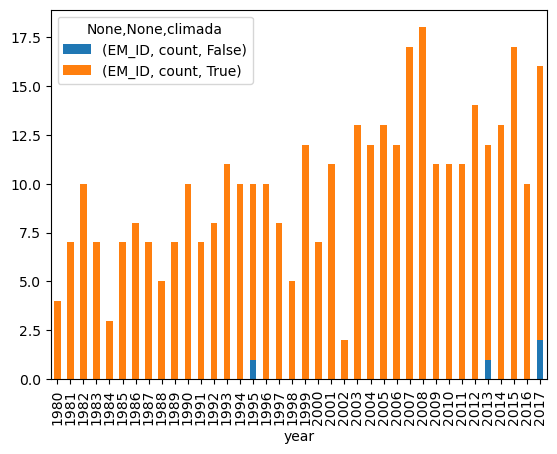

In [8]:
from matplotlib import pyplot as plt

# Visualise event frequency
counts = emdat[['year', 'EM_ID', 'climada']].drop_duplicates().groupby(['year', 'climada']).agg(['count'])
counts = counts.unstack().fillna(0)
counts.plot(kind='bar', stacked=True)

Looking at event frequency, there's definitely a jump in the 2000s. But backdating to 1980 seems reasonable, even though CLIMADA is missing some of the older events.

TODO: split this be geographical region. Make sure the assumption holds!

## Calculate return periods

First we assign return periods to each event-country combination. This was the first dataset we want to calibrate to.

In [9]:
from copy import deepcopy

# Calculate event return periods
# Note: this includes events that are in EM-DAT but not in CLIMADA. It would also be valid to restrict only to events in EM-DAT
# If so: worth finding out why the events in CLIMADA are missing. (Potentially just that there was no calculated hazard?)

rps = deepcopy(emdat)
rps = rps.reset_index()
# rps = rps[rps['climada']].reset_index()  # only include events that are in CLIMADA – not needed when we're matching to RPs rather than event losses
n_years = np.max(rps['year']) - np.min(rps['year']) + 1
rps = rps.sort_values(['country', 'emdat_impact_scaled'], ascending=[True, False])
rps['rank'] = rps.groupby(['country']).cumcount() + 1
rps['rp'] = n_years / rps['rank']
print(rps)

     index country  region_id cal_region2  year      EM_ID      ibtracsID  \
120    120     ATG         28         NA1  1995  1995-0192  1995240N11337   
58      58     ATG         28         NA1  1989  1989-0115  1989254N13340   
456    456     ATG         28         NA1  2017  2017-0381  2017242N16333   
331    331     ATG         28         NA1  2010  2010-0468  2010236N12341   
448    448     AUS         36          OC  2017  2017-0105  2017081S13152   
..     ...     ...        ...         ...   ...        ...            ...   
96      96     VUT        548          OC  1993  1993-0024  1993083S12181   
397    397     VUT        548          OC  2014  2014-0096  2014068S16169   
82      82     WSM        882          OC  1991  1991-0364  1991338S08181   
374    374     WSM        882          OC  2012  2012-0498  2012346S14180   
430    430     YEM        887          NI  2015  2015-0484  2015301N11065   

     emdat_impact  reference_year  emdat_impact_scaled  ...  \
120  3.50000

In [10]:
rps = rps[['country', 'region_id', 'cal_region2', 'year', 'EM_ID',\
           'ibtracsID', 'emdat_impact', 'reference_year', 'emdat_impact_scaled',\
           'unique_ID', 'Associated_disaster', 'Surge', 'Rain', 'Flood', 'Slide',\
           'Other', 'OtherThanSurge', 'climada', 'rank', 'rp']]

In [11]:
rps.to_csv(Path(output_dir, 'tc_full.csv'), index=False)

In [12]:
rps_country = rps[['country', 'cal_region2', 'ibtracsID', 'emdat_impact_scaled', 'rp']].rename(columns={'ibtracsID': 'event_id', 'emdat_impact_scaled': 'impact'})
rps_country.to_csv(Path(output_dir, 'tc_country.csv'), index=False)
rps_country

,country,cal_region2,event_id,impact,rp
120,ATG,NA1,1995240N11337,7.733705e+08,38.000000
58,ATG,NA1,1989254N13340,2.325601e+08,19.000000
456,ATG,NA1,2017242N16333,2.111764e+08,12.666667
331,ATG,NA1,2010236N12341,1.394594e+07,9.500000
448,AUS,OC,2017081S13152,2.988754e+09,38.000000
...,...,...,...,...,...
96,VUT,OC,1993083S12181,2.599807e+07,12.666667
397,VUT,OC,2014068S16169,2.000000e+06,9.500000
82,WSM,OC,1991338S08181,1.782167e+09,38.000000
374,WSM,OC,2012346S14180,1.336630e+08,19.000000


Then we assign return periods for whole events by region. We think this will give an improved calibration. 

In [13]:
rps_region = deepcopy(emdat)
rps_region = rps_region.reset_index()
# rps_region = rps_region[rps_region['climada']].reset_index()  # only include events that are in CLIMADA – not needed when we're matching to RPs rather than event losses
rps_region = rps_region[['cal_region2', 'ibtracsID', 'emdat_impact_scaled']].groupby(['cal_region2', 'ibtracsID']).agg('sum').reset_index()
rps_region = rps_region.sort_values(['cal_region2', 'emdat_impact_scaled'], ascending=[True, False])
rps['rank'] = rps.groupby(['cal_region2']).cumcount() + 1
rps['rp'] = n_years / rps['rank']
rps_region = rps[['cal_region2', 'ibtracsID', 'emdat_impact_scaled', 'rp']].rename(columns={'ibtracsID': 'event_id', 'emdat_impact_scaled': 'impact'})
rps_region.to_csv(Path(output_dir, 'tc_region.csv'), index=False)
rps_region

,cal_region2,event_id,impact,rp
120,NA1,1995240N11337,7.733705e+08,38.000000
58,NA1,1989254N13340,2.325601e+08,19.000000
456,NA1,2017242N16333,2.111764e+08,12.666667
331,NA1,2010236N12341,1.394594e+07,9.500000
448,OC,2017081S13152,2.988754e+09,38.000000
...,...,...,...,...
96,OC,1993083S12181,2.599807e+07,0.844444
397,OC,2014068S16169,2.000000e+06,0.826087
82,OC,1991338S08181,1.782167e+09,0.808511
374,OC,2012346S14180,1.336630e+08,0.791667


# Session info

Finally, let's dump all the relevant info here:

In [14]:
climada_core_location = '/Users/chrisfairless/Projects/CelsiusPro/climada_cp_tools/'
climada_petals_location = '/Users/chrisfairless/Projects/climada/climada_python/'
# climada_core_location = None  # If CLIMADA installed via pip

session_details_file = './session_details_TC.txt'

def dump_session(filename):
    os.system(f"echo '{datetime.datetime.now()}' > {filename}")
    os.system("echo 'Python version:' > " + filename)
    os.system("python --version >> " + filename)
    if climada_core_location:
        core_commit_hash = subprocess.check_output(["git", "-C", climada_core_location, "describe", "--always"], cwd=os.path.dirname(climada_core_location)).strip().decode()
        core_status = subprocess.check_output(["git", "-C", climada_core_location, "status"], cwd=os.path.dirname(climada_core_location)).strip().decode()
        os.system("echo '\nclimada_core commit:' >> " + filename)
        os.system("echo '(format: branch or tag - number of commits on top of that branch - commit hash)' >> " + filename)
        os.system("echo '" + core_commit_hash + "' >> " + filename)
        os.system("echo '\nclimada_core status:' >> " + filename)
        os.system("echo '" + core_status + "' >> " + filename)
    if climada_petals_location:
        petals_commit_hash = subprocess.check_output(["git", "-C", climada_petals_location, "describe", "--always"], cwd=os.path.dirname(climada_petals_location)).strip().decode()
        petals_status = subprocess.check_output(["git", "-C", climada_petals_location, "status"], cwd=os.path.dirname(climada_petals_location)).strip().decode()
        os.system("echo '\nclimada_petals commit:' >> " + filename)
        os.system("echo '(format: branch or tag - number of commits on top of that branch - commit hash)' >> " + filename)
        os.system("echo '" + petals_commit_hash + "' >> " + filename)
        os.system("echo '\nnclimada_petals status:' >> " + filename)
        os.system("echo '" + petals_status + "' >> " + filename)
    os.system("echo '\nSession details:' >> " + filename)
    os.system('conda list -e >> ' + filename)

dump_session(session_details_file)

print(datetime.datetime.now())
os.system("cat " + session_details_file)

2024-10-08 13:14:49.678791
Python version:
Python 3.11.6

climada_core commit:
(format: branch or tag - number of commits on top of that branch - commit hash)
v_0.0.2-123-g3cb258a

climada_core status:
On branch fix-freq-plot
Your branch is ahead of origin/fix-freq-plot by 4 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   climada_io_cp/cp_tracks.py
	modified:   climada_tc_cp/TCTracks_validation.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.vscode/
	climada_cp.yml
	validation_validation.ipynb

no changes added to commit (use "git add" and/or "git commit -a")

climada_petals commit:
(format: branch or tag - number of commits on top of that branch - commit hash)
countrycode_on_sea-510-g4ae9abd0

nclimada_petals status:
On branch feature/bugfix_read_entity
Changes

0